# Databricks ELT Pipeline

## Data Extraction

In [ ]:
import json
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType
from pyspark.sql.functions import col
from pyspark.sql.dataframe import DataFrame

# Start Spark session
spark = SparkSession.builder \
    .appName("Databricks ELT Pipeline") \
    .enableHiveSupport() \
    .getOrCreate()

# Set location of kaggle API credentials file
file_loc = '/FileStore/my_files/kaggle.json'

# Read the Kaggle API credentials
spark_json_df = spark.read.format('json').option('header', 'true').option('inferschemma','true').load(file_loc)
KAGGLE_USERNAME = spark_json_df.select(spark_json_df.username).take(1)[0]['username']
KAGGLE_KEY = spark_json_df.select(spark_json_df.key).take(1)[0]['key']


In [ ]:
def authenticate_kaggle(KAGGLE_USERNAME, KAGGLE_KEY):
    # Set environment variables for credentials
    os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
    os.environ['KAGGLE_KEY'] = KAGGLE_KEY

    from kaggle.api.kaggle_api_extended import KaggleApi

    api = KaggleApi()
    api.authenticate()

    print('Kaggle authentication successful')

    return api

In [ ]:
# Function to check if file exists in DBFS
def file_exists_in_dbfs(file_path):
    file_paths = dbutils.fs.ls(os.path.dirname(file_path))
    for file_info in file_paths:
        if file_info.path == file_path:
            return True
    return False

# Set path to csv file
file_path = 'dbfs:/FileStore/my_files/student_data.csv'

if not file_exists_in_dbfs(file_path):
    print("File does not exist, downloading from Kaggle...")
    try:
        api = authenticate_kaggle(KAGGLE_USERNAME, KAGGLE_KEY)        
    
        # Download the dataset from Kaggle
        !kaggle datasets download -d goyaladi/iit-admissions-dataset -p /dbfs/FileStore/my_files/ --unzip
        
    except Exception as e:
        print(e)
        print('Installing the module: pip install kaggle')
        # Handle kaggle installation if neccessary
        import sys
        import subprocess

        subprocess.check_call([sys.executable, '-m','pip','install','kaggle'])
        api = authenticate_kaggle(KAGGLE_USERNAME, KAGGLE_KEY)
else:
    print("File already exists, skipping download.")  

File already exists, skipping download.


## Data Transformation

In [ ]:
# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)
#df.printSchema()

In [ ]:
# Register the DataFrame as a temporary view
df.createOrReplaceTempView("students")

# Use Spark SQL to calculate the total fees after discount
transformed_df = spark.sql("""
SELECT *,
       Fees - `Discount on Fees` AS `fees_after_discount`
FROM students
""")

# Renaming columns
renamed_df = (transformed_df
              .withColumnRenamed("Student ID", "student_id")
              .withColumnRenamed("Student Name", "student_name")
              .withColumnRenamed("Date of Birth", "date_of_birth")
              .withColumnRenamed("Field of Study", "field_of_study")
              .withColumnRenamed("Year of Admission", "year_of_admission")
              .withColumnRenamed("Expected Year of Graduation", "expected_year_of_graduation")
              .withColumnRenamed("Current Semester", "current_semester")
              .withColumnRenamed("Specialization", "specialization")
              .withColumnRenamed("Fees", "fees")
              .withColumnRenamed("Discount on Fees", "discount_on_fees")
             )

In [ ]:
# Define the schema based on the df structure
schema = StructType([
    StructField("student_id", IntegerType(), True),
    StructField("student_name", StringType(), True),
    StructField("date_of_birth", DateType(), True),
    StructField("field_of_study", StringType(), True),
    StructField("year_of_admission", IntegerType(), True),
    StructField("expected_year_of_graduation", IntegerType(), True),
    StructField("current_semester", IntegerType(), True),
    StructField("specialization", StringType(), True),
    StructField("fees", IntegerType(), True),
    StructField("discount_on_fees", IntegerType(), True),
    StructField("fees_after_discount", IntegerType(), True)
])

# Cast the existing DataFrame to the new schema
df_with_schema = spark.createDataFrame(renamed_df.rdd, schema=schema)

table_name = 'student_data'

# Write the DataFrame into the Hive metastore as a new table if not exist
df_with_schema.write.mode("ignore").saveAsTable(f"hive_metastore.default.{table_name}")

# Assert if table is created successfully
assert spark.catalog.tableExists(table_name) == True, f"{table_name} creation unsuccessful"

## Data Loading

In [ ]:
# Load the data into a DataFrame
student_data_df = spark.sql("SELECT * FROM student_data")

# Create a temp view for analysis purposes
student_data_df.createOrReplaceTempView("student_data_view")

## Data Visualization

### Analysis - Student Count Across Five Different Fields of Study

field_of_study,student_count
Electrical Engineering,40305
Chemical Engineering,40020
Mechanical Engineering,39941
Computer Science,39960
Civil Engineering,39774


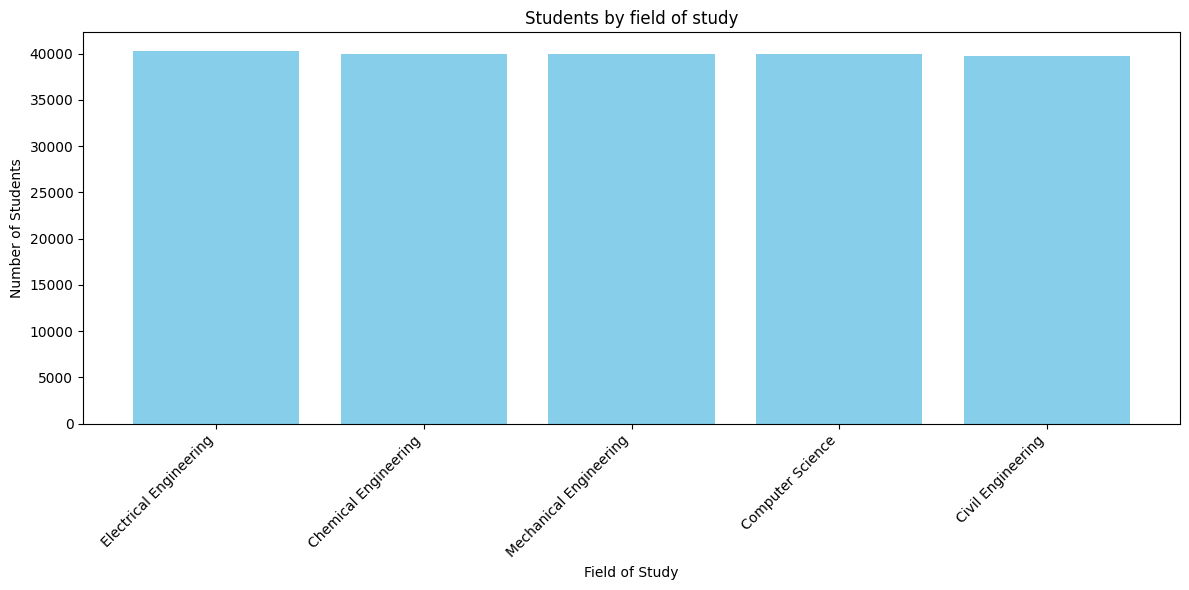

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Perform a groupBy operation and count the number of students in each field
students_by_field_df = spark.sql("""
SELECT field_of_study, COUNT(*) as student_count
FROM student_data_view
GROUP BY field_of_study
""")

# Convert the DataFrame to Pandas for plotting
df = students_by_field_df.toPandas()
display(df)
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df['field_of_study'], df['student_count'], color='skyblue')
plt.xlabel('Field of Study')
plt.ylabel('Number of Students')
plt.title('Students by field of study')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

This analysis outlines the student count across five different fields of study, indicating a fairly even distribution of students within each discipline. The fields of Electrical Engineering and Chemical Engineering have slightly higher student counts, with 40,305 and 40,020 students respectively, while Civil Engineering has the lowest at 39,774. The marginal differences suggest a balanced appeal and capacity of the institution's programs. Such parity in enrollment figures might reflect well-designed course offerings and resources allocated evenly across departments, ensuring no single program is over or under-subscribed. This balance is beneficial for maintaining diverse academic communities and optimizing resource utilization.

### Analysis - Average Fees After Discount by Field of Study

field_of_study,avg_fees_after_discount
Electrical Engineering,112629.54
Chemical Engineering,112700.74
Mechanical Engineering,112558.66
Computer Science,112570.15
Civil Engineering,112583.39


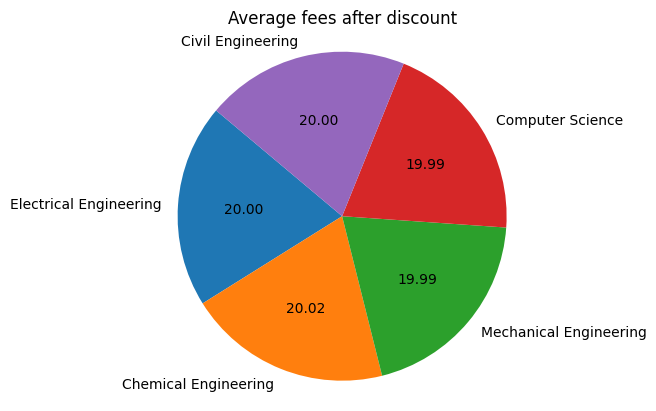

In [ ]:

average_fees_df = spark.sql("""
SELECT field_of_study, ROUND(AVG(`fees_after_discount`), 2) as avg_fees_after_discount
FROM student_data_view
GROUP BY field_of_study
""")

# Convert to Pandas DataFrame for plotting
df = average_fees_df.toPandas()
display(df)
# Creating the pie chart
plt.pie(df['avg_fees_after_discount'], labels=df['field_of_study'], autopct='%.2f', startangle=140)
plt.title('Average fees after discount')
plt.axis('equal')
plt.show()

This analysis reveals a consistent fee structure across various engineering and computer science programs, with average fees after discounts showing minimal variation among fields such as Electrical, Chemical, Mechanical, Computer Science, and Civil Engineering. The slight differences in fees, with Chemical Engineering at the higher end, suggest a standardized approach to pricing that reflects an institutional strategy of maintaining parity in educational costs. This uniformity in pricing may be part of a broader effort to attract a diverse student body across all technical disciplines without financial bias toward any specific field of study.

year_of_admission,average_fees,average_discount
2016,124993.21,12435.22
2017,125266.5,12488.46
2018,124680.1,12402.08
2019,125067.09,12505.58
2020,125328.41,12543.99
2021,125293.69,12552.9
2022,125020.85,12462.03


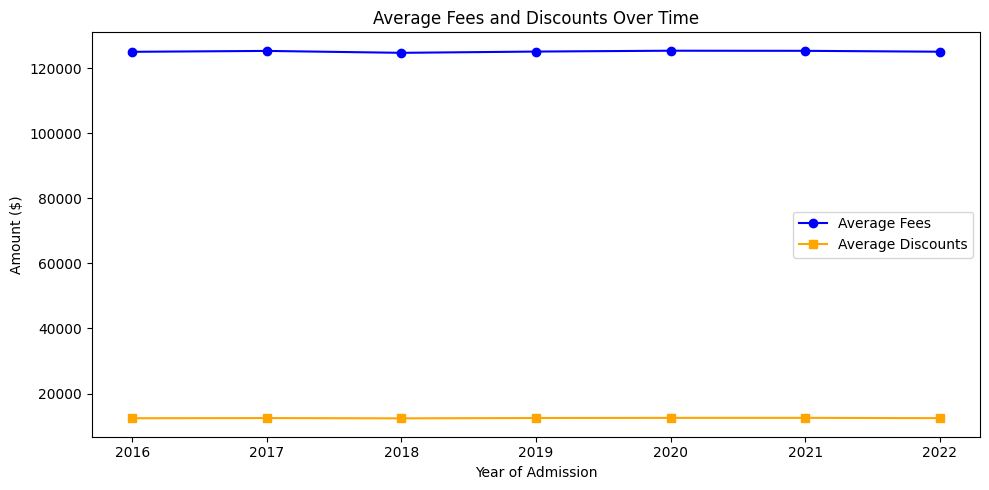

In [ ]:
# Query to compare initial fees and discount rates across different cohorts
fees_discount_query = """
SELECT 
    year_of_admission, 
    ROUND(AVG(fees), 2) AS average_fees, 
    ROUND(AVG(discount_on_fees), 2) AS average_discount
FROM 
    student_data_view
GROUP BY 
    year_of_admission
ORDER BY 
    year_of_admission
"""

df = spark.sql(fees_discount_query)
display(df)
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df.toPandas()

years = pandas_df["year_of_admission"]
average_fees = pandas_df["average_fees"]
average_discounts = pandas_df["average_discount"]

# Plotting the data
plt.figure(figsize=(10, 5))

# Plot average fees line
plt.plot(years, average_fees, marker='o', label='Average Fees', color='blue')

# Plot average discounts line
plt.plot(years, average_discounts, marker='s', label='Average Discounts', color='orange')

# Add titles and labels
plt.title('Average Fees and Discounts Over Time')
plt.xlabel('Year of Admission')
plt.ylabel('Amount ($)')
plt.xticks(years)  # Set x-axis ticks to be the years
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

This analysis showcases the average fees and discounts for student cohorts from 2016 to 2022, showing a stable fee structure with slight annual fluctuations. Over these seven years, average fees hover around the 125,000 mark, while average discounts remain close to 12,500. The consistency in fees suggests a controlled pricing strategy without significant increases, possibly reflecting a commitment to keeping education costs predictable. Notably, the discount amount also remains relatively stable, indicating a steady financial aid policy. The year 2020 stands out with the highest average fees and discounts, hinting at a potential response to unique circumstances such as the onset of the COVID-19 pandemic. Overall, the institution's approach to pricing and discounts appears methodical and consistent year over year.

## Conclusion & Recommendations

The analyses conducted on the student data from 2016 to 2022 reveal several key findings:

1. **Stable Fee Structure:** The average fees for students remain relatively consistent over the years, with slight fluctuations, indicating a stable tuition pricing policy by the institution.

2. **Consistent Discount Policy:** Average discounts offered to students also show minimal variation, suggesting a steady financial aid strategy that aligns closely with the fees charged.

3. **Balanced Enrollment:** Student counts across various fields of study like Electrical, Chemical, Mechanical, Computer Science, and Civil Engineering are evenly distributed, reflecting an equitable appeal of the institution's academic programs.

4. **Slight Yearly Variations:** The year 2020 shows a marginal increase in both fees and discounts, which may correlate with special circumstances such as adjustments made due to the COVID-19 pandemic.

Based on these observations, the following recommendations can be made:

1. **Review Fee Adjustments:** Given the relatively stable fee and discount trends, the institution should continue to monitor these closely, ensuring they reflect inflation and cost-of-living changes without burdening students financially.

2. **Analyze External Factors:** An investigation into the fee and discount spike in 2020 may provide insights into how external factors affect financial policies, helping to better prepare for future anomalies.

3. **Enhance Marketing Strategies:** The balanced enrollment across fields suggests effective marketing and program development. These strategies should be maintained and, where possible, enhanced to attract an even more diverse student body.

4. **Further Research on Retention:** Additional research could be beneficial to understand the retention dynamics within the student cohorts, aiming to improve student engagement and success rates.

5. **Financial Aid Optimization:** The institution could consider tailoring financial aid packages more closely with students' needs and backgrounds, potentially using a data-driven approach to optimize aid distribution.

6. **Longitudinal Tracking:** Establish a system for longitudinal tracking of cohorts to gain deeper insights into student progression and outcomes, informing academic support services and policy adjustments.

By maintaining its current strategies while also considering these recommendations, the institution can continue to uphold its academic standards and financial sustainability.